In [1]:
import pandas as pd
act = pd.read_csv("D:/000-Master/UserClustering/sample_activity_Oct-22-2018.csv")
act.rename(columns = {'Unnamed: 0':'index'},inplace=True)
loc = pd.read_csv("D:/000-Master/UserClustering/sample_location_Oct-22-2018.csv")
loc.rename(columns = {'Unnamed: 0':'index'},inplace=True)
city_list = (dict(loc['city'].value_counts()))

act['start_date'] = act['local_start_time'].astype(str).str[:10]
act['local_start_time'] = act['local_start_time'].astype(str).str[:19]
act['local_start_time'] = pd.to_datetime(act['local_start_time'])

act['local_end_time'] = act['local_end_time'].astype(str).str[:19]
act['local_end_time'] = pd.to_datetime(act['local_end_time'])

import numpy as np
cols = ['loc_id','center_lat','center_lon']
df = loc[cols]

df.rename(columns = {'loc_id':'orig_loc_id'},inplace=True)
x = pd.merge(act, df, on="orig_loc_id")
x.rename(columns = {'center_lat':'orig_lat',
                   'center_lon':'orig_lon'},inplace=True)

df.rename(columns = {'orig_loc_id':'dest_loc_id'},inplace=True)
x = pd.merge(x, df, on="dest_loc_id")
x.rename(columns = {'center_lat':'dest_lat',
                   'center_lon':'dest_lon'},inplace=True)
act = x

user = act.groupby(['user_id']).size().reset_index(name = 'user_counts')
numTrips = act.groupby(['user_id','orig_loc_id','dest_loc_id']).size().reset_index(name='counts')
# print(len(numTrips[numTrips.duplicated(['orig_loc_id','dest_loc_id'], keep=False)])) # 0 repeated lon and lat
# numTrips.head()
numTrips = pd.merge(numTrips, act[['orig_loc_id','dest_loc_id','orig_lat','orig_lon','dest_lat','dest_lon','city']], 
                    on = ['orig_loc_id','dest_loc_id'])
numTrips = pd.merge(numTrips, user, on = ['user_id'])
numTrips = numTrips.drop_duplicates()
numTrips['freq'] = numTrips['counts']/numTrips['user_counts']
numTrips.head()

D:\Download\Anaconda\A3\lib\site-packages\pandas\core\frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,user_id,orig_loc_id,dest_loc_id,counts,orig_lat,orig_lon,dest_lat,dest_lon,city,user_counts,freq
0,2,14,15,29,32.301514,-110.831139,32.285600,-110.945060,tucson,119,0.243697
29,2,14,23,4,32.301514,-110.831139,32.221050,-110.971110,tucson,119,0.033613
33,2,14,12777,1,32.301514,-110.831139,32.250938,-110.927725,tucson,119,0.008403
34,2,14,14571,8,32.301514,-110.831139,32.236338,-110.955351,tucson,119,0.067227
42,2,14,18053,4,32.301514,-110.831139,32.224884,-110.971948,tucson,119,0.033613


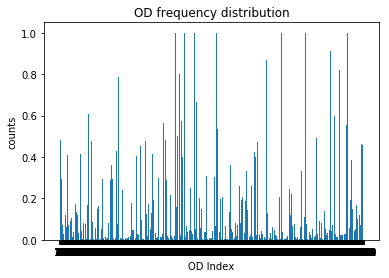

In [24]:
# Descriptve
import numpy as np
import matplotlib.pyplot as plt
height = numTrips['freq']
bars = range(len(numTrips))

plt.bar(bars, height)
# Create names on the x-axis
plt.xticks(bars, bars)
plt.title('OD frequency distribution')
plt.xlabel('OD Index')
plt.ylabel('counts')
# Show graphic
plt.show()

In [180]:
import sys #PROB
!{sys.executable} -m pip install mpl_toolkits.basemap

  Could not find a version that satisfies the requirement mpl_toolkits.basemap (from versions: )
No matching distribution found for mpl_toolkits.basemap


In [2]:
numTrips = numTrips.loc[numTrips['city'] == list(city_list.keys())[1]]

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

In [3]:
### Important Location clustering - Origin
y = numTrips['orig_lat']
x = numTrips['orig_lon']

import matplotlib.pyplot as plt
plt.scatter(x,y)
plt.xlabel("Origin Longitude")
plt.ylabel("Origin Latitude")
plt.title("Spatial Distribution in "+str(list(city_list.keys())[1]))
plt.show()

print(len(numTrips))

<Figure size 640x480 with 1 Axes>

1559


In [4]:
df = numTrips[['orig_loc_id','orig_lat','orig_lon']]
df = df.drop_duplicates()
df = df.loc[df.index.repeat(len(df))].reset_index(drop=True) # reset index

df2 = numTrips[['orig_loc_id','orig_lat','orig_lon']]
df2 = df2.drop_duplicates()
df2 = pd.concat([df2]*len(df2), ignore_index=True)
df2.rename(columns = {'orig_loc_id':'orig_loc_id_2','orig_lat': 'orig_lat_2','orig_lon':'orig_lon_2'},inplace=True)

In [5]:
df3 = df.join(df2, lsuffix='_df', rsuffix='_df2') # IMPORTANT!!!
df3.head()

,orig_loc_id,orig_lat,orig_lon,orig_loc_id_2,orig_lat_2,orig_lon_2
0,14,32.301514,-110.831139,14,32.301514,-110.831139
1,14,32.301514,-110.831139,15,32.285600,-110.945060
2,14,32.301514,-110.831139,21,32.236122,-110.945051
3,14,32.301514,-110.831139,23,32.221050,-110.971110
4,14,32.301514,-110.831139,12777,32.250938,-110.927725


In [6]:
# import sys
# !{sys.executable} -m pip install geopy

from sklearn.metrics.pairwise import pairwise_distances 
from geopy.distance import vincenty

# unit in km
df3['Vincenty_distance'] = df3.dropna().apply(lambda x: vincenty((x['orig_lat'], x['orig_lon']), (x['orig_lat_2'], x['orig_lon_2'])).km, axis = 1)
distance_matrix = df3.pivot_table(index=['orig_loc_id'],columns=['orig_loc_id_2'],values='Vincenty_distance')
distance_matrix.head()

orig_loc_id_2,14,15,21,23,48,50,54,65,89,90,...,18742,18745,18746,18750,18755,18760,18763,18765,18771,18774
orig_loc_id,,,,,,,,,,,,,,,,,,,,,
14,0.000000,10.874523,12.952520,15.923472,15.309393,12.243283,14.935807,20.423765,21.026377,48.016507,...,9.757719,9.292371,18.169057,10.596782,14.359223,17.307644,17.750777,8.769755,10.713967,10.657312
15,10.874523,0.000000,5.486717,7.567213,7.594129,1.511901,8.038544,13.369326,15.451444,38.395785,...,6.683768,7.280471,11.195079,13.066907,6.413822,7.626149,14.743909,13.313821,0.217063,0.217229
21,12.952520,5.486717,0.000000,2.970960,12.644409,6.111890,13.271255,18.188056,20.584244,40.769584,...,4.037012,4.852022,5.918875,10.224683,1.407344,11.553042,9.479671,11.435352,5.657680,5.528880
23,15.923472,7.567213,2.970960,0.000000,13.794518,7.677067,14.589600,18.936456,21.612593,39.527768,...,6.743250,7.510180,3.821841,12.245369,1.564753,11.952594,9.239538,13.795349,7.771810,7.674966
48,15.309393,7.594129,12.644409,13.794518,0.000000,6.559439,1.105838,5.811293,7.940217,32.738973,...,14.251087,14.797128,17.614311,20.431872,13.155757,3.580774,22.116591,20.321957,7.518414,7.671160


In [66]:
distance_matrix.describe()

orig_loc_id_2,14,15,48,50,54,65,89,90,93,96,...,18582,18602,18603,18612,18619,18638,18703,18704,18741,18763
count,449.000000,449.000000,449.000000,449.000000,449.000000,449.000000,449.000000,449.000000,449.000000,449.000000,...,449.000000,449.000000,449.000000,449.000000,449.000000,449.000000,449.000000,449.000000,449.000000,449.000000
mean,15.556724,11.524338,15.274566,11.854960,15.645854,19.545359,21.443158,41.832768,14.770487,12.678303,...,10.854209,10.898583,12.117605,15.555124,11.920995,36.082635,12.911342,11.570453,14.651724,14.745724
std,7.734112,7.617747,8.708074,7.689549,8.757979,9.597373,9.808951,10.124978,8.545542,8.232148,...,7.540970,7.633779,8.028811,7.756277,7.463838,10.866275,7.658179,7.627296,7.221453,8.269260
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.616454,6.338653,9.538299,6.463412,9.849984,13.085757,15.299355,35.866365,8.947225,6.940985,...,5.026617,5.211967,6.447804,9.820110,6.525376,29.754724,8.093660,6.385478,9.339224,9.296948
50%,14.535088,9.879648,13.685990,10.449186,14.233797,18.860846,21.090141,41.532620,13.079873,10.678020,...,9.365714,9.172667,10.162244,14.907865,10.947408,34.994827,11.168288,9.944533,13.575787,12.979828
75%,19.292338,14.743909,20.441461,15.412540,20.785981,25.262619,27.488940,47.594830,19.610695,16.451362,...,14.413621,14.478021,15.901238,19.768382,15.568430,41.429615,15.901128,14.874895,18.283772,18.570628
max,52.238336,48.433691,54.808637,48.776030,55.667827,59.426889,62.375933,73.626162,54.262593,48.345361,...,44.901636,43.595083,46.712262,53.713122,44.871581,72.856726,51.655426,48.559395,48.443044,52.027505


In [9]:
loc = loc.loc[loc['city'] == 'tucson']

### Convert lon and lat into distance
### Origin is bottom left
import math
O = [min(loc['center_lat']),min(loc['center_lon'])]
loc['center_x'] = (loc['center_lon']-O[1])*111.2*np.cos(np.radians(loc['center_lat'])) # x - lon - km
loc['center_y'] = (loc['center_lat']-O[0])*111.2 # y - lat - km
# loc.head()
data = loc.iloc[:,10:12]
data.head()

,center_x,center_y
10,50.433670,28.956146
17,47.525670,85.385365
20,37.225158,44.517586
23,33.843731,48.123468
24,31.924634,48.867819


In [10]:
# method 2: check if vincenty dist is right, faster than the above one
df = loc[['loc_id','center_y','center_x']]
df = df.drop_duplicates()
df = df.loc[df.index.repeat(len(df))].reset_index(drop=True) # reset index

df2 = loc[['loc_id','center_y','center_x']]
df2 = df2.drop_duplicates()
df2 = pd.concat([df2]*len(df2), ignore_index=True)
df2.rename(columns = {'loc_id':'loc_id_2','center_y': 'center_y_2','center_x':'center_x_2'},inplace=True)

df3 = df.join(df2, lsuffix='_df', rsuffix='_df2') # IMPORTANT!!!
print(df3.shape)
df3.head()

# dist matrix
df3['distance'] = np.sqrt(np.square(df3['center_y']-df3['center_y_2'])+np.square(df3['center_x']-df3['center_x_2']))
distance_matrix = df3.pivot_table(index=['loc_id'],columns=['loc_id_2'],values='distance')
distance_matrix.head()

(1413721, 6)


loc_id_2,14,15,21,23,48,50,52,54,63,65,...,18747,18750,18751,18755,18757,18760,18763,18765,18771,18774
loc_id,,,,,,,,,,,,,,,,,,,,,
14,0.000000,10.846758,12.921420,15.886181,15.303297,12.213908,17.352925,14.936288,22.227280,20.433641,...,8.731799,10.621124,10.235971,14.325265,7.809076,17.282814,17.757134,8.796813,10.686948,10.630089
15,10.846758,0.000000,5.502024,7.576603,7.617065,1.510982,6.841810,8.064795,14.423095,13.406125,...,13.007319,13.094917,3.482955,6.426861,8.372996,7.632525,14.793445,13.328838,0.216884,0.216688
21,12.921420,5.502024,0.000000,2.964773,12.686208,6.132133,6.085139,13.314872,18.887419,18.245446,...,11.066058,10.221597,2.953521,1.404507,6.745321,11.585183,9.512049,11.419223,5.672969,5.543511
23,15.886181,7.576603,2.964773,0.000000,13.836627,7.694506,4.859958,14.632179,19.304631,18.997410,...,13.417374,12.227869,5.814057,1.561407,9.433196,11.991104,9.264032,13.766743,7.781021,7.683383
48,15.303297,7.617065,12.686208,13.836627,0.000000,6.580779,10.434133,1.104979,7.139851,5.824973,...,20.072930,20.484671,11.099294,13.198354,15.655110,3.576174,22.190846,20.363711,7.540609,7.693825


Estimated number of clusters: 119
Silhouette Coefficient: 0.004


D:\Download\Anaconda\A3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


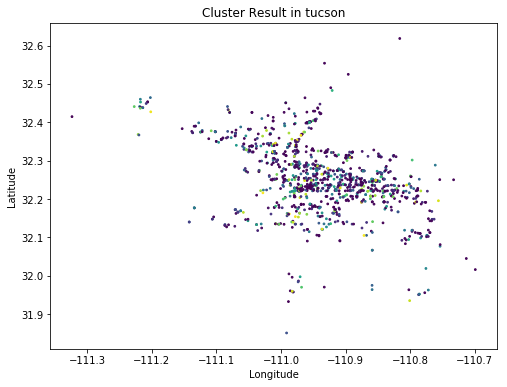

In [13]:
from sklearn.cluster import DBSCAN 
db = DBSCAN(metric='precomputed',eps = 0.8, min_samples = 2).fit(distance_matrix)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
from sklearn import metrics
print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(distance_matrix, labels))

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
# print(labels)
data = loc[['loc_id','center_lat','center_lon']]
data['label'] = labels

import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.scatter(data['center_lon'],data['center_lat'], c = data['label'], s = 3)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Cluster Result in " + str(list(city_list.keys())[1]))
plt.show()

In [15]:
import collections, numpy
print(collections.Counter((db.labels_)))

Counter({1: 456, -1: 89, 43: 23, 9: 21, 13: 21, 35: 21, 4: 19, 49: 19, 11: 18, 28: 18, 16: 16, 46: 16, 17: 15, 7: 13, 14: 13, 67: 12, 29: 11, 36: 10, 38: 9, 3: 8, 21: 8, 24: 7, 39: 7, 41: 7, 47: 7, 48: 7, 61: 7, 2: 6, 19: 6, 23: 6, 30: 6, 52: 6, 55: 6, 58: 6, 59: 6, 63: 6, 78: 6, 18: 5, 20: 5, 60: 5, 62: 5, 65: 5, 92: 5, 102: 5, 107: 5, 111: 5, 8: 4, 10: 4, 22: 4, 26: 4, 27: 4, 31: 4, 32: 4, 40: 4, 44: 4, 69: 4, 72: 4, 75: 4, 91: 4, 101: 4, 103: 4, 112: 4, 0: 3, 5: 3, 6: 3, 12: 3, 15: 3, 33: 3, 37: 3, 51: 3, 53: 3, 54: 3, 56: 3, 64: 3, 74: 3, 79: 3, 81: 3, 84: 3, 86: 3, 88: 3, 89: 3, 93: 3, 94: 3, 99: 3, 104: 3, 105: 3, 106: 3, 115: 3, 25: 2, 34: 2, 42: 2, 45: 2, 50: 2, 57: 2, 66: 2, 68: 2, 70: 2, 71: 2, 73: 2, 76: 2, 77: 2, 80: 2, 82: 2, 83: 2, 85: 2, 87: 2, 90: 2, 95: 2, 96: 2, 97: 2, 98: 2, 100: 2, 108: 2, 109: 2, 110: 2, 113: 2, 114: 2, 116: 2, 117: 2, 118: 2})


In [187]:
# To see if the distance is small enough
one = orig.loc[orig['label'] == 5]

one_1 = one.loc[one.index.repeat(len(one))].reset_index(drop=True) # reset index

one_2 = one
one_2 = pd.concat([one_2]*len(one_2), ignore_index=True)
one_2.rename(columns = {'orig_loc_id':'orig_loc_id_2','orig_lat': 'orig_lat_2','orig_lon':'orig_lon_2'},inplace=True)

one_3 = one_1.join(one_2, lsuffix='_one_1', rsuffix='_one_2') # IMPORTANT!!!

from sklearn.metrics.pairwise import pairwise_distances 
from sklearn.cluster import DBSCAN 
from geopy.distance import vincenty

# unit in km
one_3['Vincenty_distance'] = one_3.dropna().apply(lambda x: vincenty((x['orig_lat'], x['orig_lon']), (x['orig_lat_2'], x['orig_lon_2'])).km, axis = 1)
one_distance_matrix = one_3.pivot_table(index=['orig_loc_id'],columns=['orig_loc_id_2'],values='Vincenty_distance')
one_distance_matrix.head()

orig_loc_id_2,3317,5448,18109
orig_loc_id,,,
3317,0.000000,5.764201,15.576291
5448,5.764201,0.000000,18.335564
18109,15.576291,18.335564,0.000000


In [188]:
# Without pre-computed dist-matrix
db = DBSCAN(eps = 0.05, min_samples = 4).fit(numTrips[['orig_lat','orig_lon']].drop_duplicates())
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

from sklearn import metrics
print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(numTrips[['orig_lat','orig_lon']].drop_duplicates(), labels))

Estimated number of clusters: 3
Silhouette Coefficient: 0.451


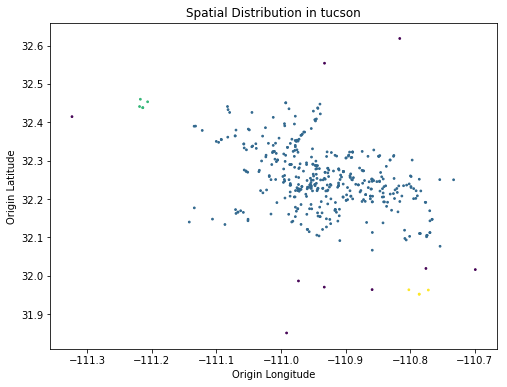

In [190]:
# print(labels)
orig = numTrips[['orig_lat','orig_lon']]
orig = orig.drop_duplicates()
orig['label'] = labels

import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.scatter(orig['orig_lon'],orig['orig_lat'], c = orig['label'], s = 3)

plt.xlabel("Origin Longitude")
plt.ylabel("Origin Latitude")
plt.title("Spatial Distribution in " + str(list(city_list.keys())[1]))
plt.show()